# Inference in PyTorch, what do the wrappers mean? What's best?

> A tour through PyTorch's various context managers, torch script, and comparing performance

- toc: true
- badges: true
- comments: true
- image: images/chart-preview.png
- category: torch

---

This blog is also a Jupyter notebook available to run from the top down. There will be code snippets that you can then run in any environment. In this section I will be posting what version of `torch` I am currently running at the time of writing this:


* `torch`: 1.10.2

Benchmarks were ran on a NVIDIA RTX 3070 Laptop GPU

---

## Why are we doing this?

Earlier today, [Francesco Pochetti](https://twitter.com/Fra_Pochetti) had pinged on the fastai discord asking if when using inference for a torch model, whether `no_grad` was needed when the model has been scripted. This then got me curious on timings, which as we've seen previously I *love* to do benchmarks like this!

So, I followed along PyTorch's fantastic [inference tutorial using TorchScript](https://pytorch.org/tutorials/recipes/torchscript_inference.html) and went to work! 

What we'll explore in this article are the three "modes" for running a torch model:
- Regular
- `no_grad`
- `inference_mode`

How each of them differ in what they do, and overall how the timings for each performed.

For the initial testing, we'll use a resnet18 on three different batch sizes (1, 16, and 64) to see the full effect of our efforts

## Okay, so what are these [modes](https://pytorch.org/docs/stable/notes/autograd.html#grad-modes)?

When we simply call `model(torch.tensor([...]))`, a trace of the functions called is stored, along with the results of each layer, so that later gradients can be calculated if needed. This can become a time sink,  and greatly increases the memory being used during inference. To speed things up, in pytorch you would typically wrap the call to `model()` with a `no_grad()` context manager. Under this, computations are never recorded in the model as the inference is performed, and looks like so:

```python
with torch.no_grad():
    model(torch.tensor([...]))
```

Finally, we get to `inference_mode` which is the **extreme** version of `no_grad`. With this context manager, you should assume that you'll **never** need to have any recordings done in the backwards of the graph (like `no_grad`), *and* any tensors made during inference mode won't be used for any computations touching autograd later. Hence the naming, `inference_mode`.

It looks like so:

```python
with torch.inference_mode():
    model(torch.tensor([...]))
```

## Making a Baseline

When doing experiments, it's always important to make proper benchmarks! Since we're comparing three modes, as well as two different models (torch scripted vs not), the the initial benchmark will be of our base model and torch scripted model without any context managers.

First let's make our models:

In [1]:
import torch
from torchvision.models import resnet18

baseline_resnet = resnet18(pretrained=True).eval()
scripted_resnet = torch.jit.script(baseline_resnet).eval()

ModuleNotFoundError: No module named 'torch'

Next we'll setup our batches:

In [ ]:
bs = [1,16,64]
batches = [torch.rand(size, 3, 224, 224) for size in bs]

And finally set them all to CUDA

In [3]:
baseline_resnet.cuda()
scripted_resnet.cuda()
for i in range(len(batches)):
    batches[i] = batches[i].cuda()

We'll also keep this interesting by keeping track of the allocated memory used by each. First we'll grab the current memory being used:

In [ ]:
def get_mb(key):
    "A helpful function to get a readable size of an allocation"
    sz = torch.cuda.memory_stats()[key]
    return sz // 1024 // 1024

In [5]:
get_mb("allocated_bytes.all.current")

91

This is how much our current memory usage is, and then we can track the peak memory usage once we start doing inference!

Lastly we'll make some dictionaries to provide quick access to what we need:

In [6]:
import contextlib

modes = {
    "none":contextlib.suppress,
    "no_grad":torch.no_grad,
    "inference_mode":torch.inference_mode
}

models = {
    "baseline":baseline_resnet,
    "scripted":scripted_resnet
}

ranges = {
    1:1000,
    16:100,
    64:10
}

Now we just wrap up our configuration to get us some benchmarks! The latter half of this blog will be looking at the data:

In [7]:
import time
from prettytable import PrettyTable

def benchmark_modes():
    overall_reports = []
    for mode in ["none", "no_grad", "inference_mode"]:
        for batch in batches:
            num_times = ranges[batch.shape[0]]
            for model_type in ["baseline", "scripted"]:  
                total_time = 0
                total_memory = 0
                for i in range(num_times):
                    torch.cuda.reset_peak_memory_stats()
                    initial_memory = get_mb("allocated_bytes.all.current")
                    start_time = time.perf_counter_ns()
                    with modes[mode]():
                        _ = models[model_type](batch)
                    torch.cuda.synchronize()
                    total_time += (time.perf_counter_ns() - start_time)/1e6
                    peak_memory = get_mb("allocated_bytes.all.peak")
                    total_memory += peak_memory - initial_memory
                overall_reports.append(
                    {
                        "mode":mode,
                        "batch_size":batch.shape[0],
                        "model_type":model_type,
                        "time":round(total_time/num_times, 2),
                        "memory_used":round(total_memory/num_times, 2),
                    }
                )
    return overall_reports

In [16]:
results = benchmark_modes()

## Examining the Results

Let's dive deep into our results. First we'll look at everything, based on the context manager and the batch size:

In [27]:
#hide_input
import copy
print("Experiment Results:")
table = PrettyTable(["Context Mode", "Batch Size", "Model Type", "Average Time Taken (ms)", "Average Total Memory Used (mb)"])
prev_bs = None
prev_mode = None
reports = copy.deepcopy(results)
for report in reports:
    if prev_mode == report["mode"]:
        report["mode"] = ""
    else:
        prev_mode = None
    if prev_bs == report["batch_size"]:
        report["batch_size"] = ""
    else:
        prev_bs = None
    if prev_bs is None: prev_bs = report["batch_size"]
    if prev_mode is None: prev_mode = report["mode"]
    table.add_row(report.values())
print(table)

Experiment Results:
+----------------+------------+------------+-------------------------+--------------------------------+
|  Context Mode  | Batch Size | Model Type | Average Time Taken (ms) | Average Total Memory Used (mb) |
+----------------+------------+------------+-------------------------+--------------------------------+
|      none      |     1      |  baseline  |           1.78          |              33.0              |
|                |            |  scripted  |           1.39          |              33.0              |
|                |     16     |  baseline  |           7.65          |             345.95             |
|                |            |  scripted  |           7.69          |             346.0              |
|                |     64     |  baseline  |          26.51          |             1389.5             |
|                |            |  scripted  |          26.53          |             1389.5             |
|    no_grad     |     1      |  baseline  |

We can see that generally the scripted model tends to be slightly faster, independent  of the context manager being used. It also uses the same memory footprint as the non-scripted model. 

But what if we compare by each context manager themselves?

In [127]:
#hide
table = PrettyTable(["Model Type", "Batch Size", "Context Mode", "Average Time Taken (ms)", "Average Total Memory Used (mb)"])
prev_bs = None
prev_mode = None
reports = copy.deepcopy(results)
reports = sorted(reports, key=lambda x: (x["model_type"], x["batch_size"]))
for report in reports:
    table.add_row([report[key] for key in ["model_type", "batch_size",  "mode", "time", "memory_used"]])
    

In [70]:
#hide_input
for bs, (start,end) in [[1,(0,3)],[16,(3,6)],[64,(6,9)]]:
    print(
        table.get_string(
            sort_key= lambda x: (x["Batch Size"], x["Model Type"]),
            fields = list(table.field_names)[2:],
            title=f"Baseline Model, Batch Size {bs}",
            start=start,
            end=end,
            hrules=0
        )
    )

+---------------------------------------------------------------------------+
|                        Baseline Model, Batch Size 1                       |
+----------------+-------------------------+--------------------------------+
|  Context Mode  | Average Time Taken (ms) | Average Total Memory Used (mb) |
+----------------+-------------------------+--------------------------------+
|      none      |           1.78          |              33.0              |
|    no_grad     |           1.63          |              13.0              |
| inference_mode |           1.58          |              13.0              |
+----------------+-------------------------+--------------------------------+
+---------------------------------------------------------------------------+
|                       Baseline Model, Batch Size 16                       |
+----------------+-------------------------+--------------------------------+
|  Context Mode  | Average Time Taken (ms) | Average Total Memor

For our non-scripted model, we find that for a batch size of 1, inference mode does the best! We see an average speedup of 12%!

However, as the batch size increases, this speedup becomes less and less radical, becoming only a fraction of a millisecond. 

> Note: Notice the importance of having any context manager vs none in the total memory used. We reduced it from 1.3gb to 392mb being used, which is important!

Does this pattern continue for our scripted model?

In [72]:
#hide_input
for bs, (start,end) in [[1,(9,12)],[16,(12,15)],[64,(15,18)]]:
    print(
        table.get_string(
            sort_key= lambda x: (x["Batch Size"], x["Model Type"]),
            fields = list(table.field_names)[2:],
            title=f"Scripted Model, Batch Size {bs}",
            start=start,
            end=end,
            hrules=0
        )
    )

+---------------------------------------------------------------------------+
|                        Scripted Model, Batch Size 1                       |
+----------------+-------------------------+--------------------------------+
|  Context Mode  | Average Time Taken (ms) | Average Total Memory Used (mb) |
+----------------+-------------------------+--------------------------------+
|      none      |           1.39          |              33.0              |
|    no_grad     |           1.32          |              13.0              |
| inference_mode |           1.29          |              13.0              |
+----------------+-------------------------+--------------------------------+
+---------------------------------------------------------------------------+
|                       Scripted Model, Batch Size 16                       |
+----------------+-------------------------+--------------------------------+
|  Context Mode  | Average Time Taken (ms) | Average Total Memor

Again, we do see this pattern occur even here! But, it looks like we have a time decrease, doesn't it? Our scripted model actually is a decent chunk faster in some cases:

In [217]:
#hide_input
import operator
for bs, (start,end) in [[1,(18,12)],[16,(12,6)],[64,(6,0)]]:
    print(
        table.get_string(
            sort_key=operator.itemgetter(2,3),
            fields = table.field_names[:1] + table.field_names[2:],
            reversesort=True,
            sortby="Batch Size",
            title=f"Scripted Model, Batch Size {bs}",
            start=end,
            end=start,
            hrules=0
        )
    )

+----------------------------------------------------------------------------------------+
|                              Scripted Model, Batch Size 1                              |
+------------+----------------+-------------------------+--------------------------------+
| Model Type |  Context Mode  | Average Time Taken (ms) | Average Total Memory Used (mb) |
+------------+----------------+-------------------------+--------------------------------+
|  baseline  |      none      |           1.78          |              33.0              |
|  scripted  |      none      |           1.39          |              33.0              |
|  baseline  |    no_grad     |           1.63          |              13.0              |
|  scripted  |    no_grad     |           1.32          |              13.0              |
|  baseline  | inference_mode |           1.58          |              13.0              |
|  scripted  | inference_mode |           1.29          |              13.0              |

We see it specifically packing the punch when there was a batch size of 1. Otherwise no matter the context manager used, it always added in a few hundredth's of a second of time. 

But when does the loss of value happen? Let's find out.

We'll run a fresh set of benchmarks, examining the batch size from 1 to 8:

In [322]:
for i in range(1,9):
    ranges[i] = 100

batches = [torch.rand(i, 3, 224, 224) for i in range(1,9)]
for i in range(len(batches)):
    batches[i] = batches[i].cuda()
results = benchmark_modes()

Next, we'll plot a chart of `batch_size` x `time (ms)`, looking at the distribution based on each kind:

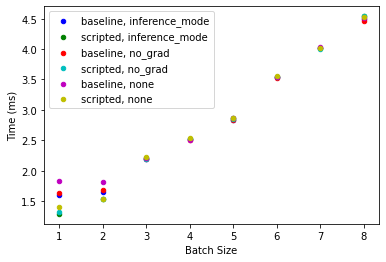

In [328]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
df = pd.DataFrame(results)
df.columns = 'mode', 'Batch Size', 'model_type', 'Time (ms)', 'memory_used'
fig, ax = plt.subplots()
i = 0
colors = "b","g",'r','c','m','y'
for (key, grp) in df.groupby(['mode']):
    for (key2, grp2) in grp.groupby(["model_type"]):
        ax = grp2.plot(ax=ax, kind='scatter', x='Batch Size', y='Time (ms)', label=f'{key2}, {key}', c=colors[i])
        i += 1

plt.legend(loc='best')
plt.show()

We see that for a single item and two, it's **extremely** important to use the right context manager, but as we increase our batch size it matters less and less until we hit 8.

For morbid curiosity, I decided to check how 8 to 16 might look, and here's those results:

In [331]:
for i in range(8,16):
    ranges[i] = 100

batches = [torch.rand(i, 3, 224, 224) for i in range(8,16)]
for i in range(len(batches)):
    batches[i] = batches[i].cuda()
results = benchmark_modes()

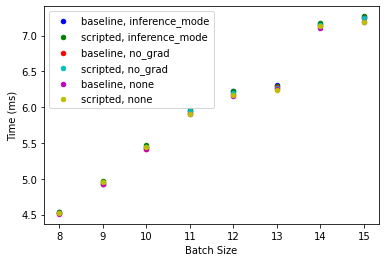

In [333]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
df = pd.DataFrame(results)
df.columns = 'mode', 'Batch Size', 'model_type', 'Time (ms)', 'memory_used'
fig, ax = plt.subplots()
i = 0
colors = "b","g",'r','c','m','y'
for (key, grp) in df.groupby(['mode']):
    for (key2, grp2) in grp.groupby(["model_type"]):
        ax = grp2.plot(ax=ax, kind='scatter', x='Batch Size', y='Time (ms)', label=f'{key2}, {key}', c=colors[i])
        i += 1

plt.legend(loc='best')
plt.show()

We find yet again that the distribution between the different modes is ~ <.1 milliseconds.

## Finally, what about CPU?

Here's our experiment again, performed on a CPU:

In [ ]:
#hide
for i in range(1,8):
    ranges[i] = 10

batches = [torch.rand(i, 3, 224, 224) for i in range(1,8)]
for i in range(len(batches)):
    batches[i] = batches[i].cpu()
for model in models.values():
    model.cpu()
results = benchmark_modes()

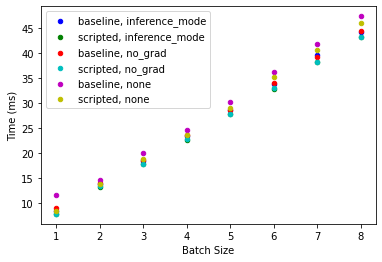

In [337]:
#hide_input
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
df = pd.DataFrame(results)
df.columns = 'mode', 'Batch Size', 'model_type', 'Time (ms)', 'memory_used'
fig, ax = plt.subplots()
i = 0
colors = "b","g",'r','c','m','y'
for (key, grp) in df.groupby(['mode']):
    for (key2, grp2) in grp.groupby(["model_type"]):
        ax = grp2.plot(ax=ax, kind='scatter', x='Batch Size', y='Time (ms)', label=f'{key2}, {key}', c=colors[i])
        i += 1

plt.legend(loc='best')
plt.show()

We see a different story on CPU, where the difference of running `no_grad` or `inference_mode` matters *much* more, (which we'd expect), and `inference_mode` on occasion being slightly faster than `no_grad`. 

## What to take away from this?

The takeaway from this experiment is that unless you're dealing with smaller batch sizes (such as single image inference), the context manager you use and whether to use a scripted model *could* be negligible when it comes to the gains in performance on a GPU. The cost of evaluating the model exceeded the performance gain of not tracking the operations as the batch size increases.

I'd think this also could matter more once a bigger model is involved, as there's even more calculations and the time sink would increase. 